In [16]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import animation
from matplotlib import gridspec
from scipy.stats import norm
from cmath import sqrt
from time import time
π = np.pi
num_points = 500
tol = 1e-14

In [17]:
%matplotlib inline
plt.rcParams["figure.dpi"] = 300

In [18]:
def dist(k,θ,r,N,λ) :
    '''
    Calculates the distance from the array element (middle of the antenna array is origin) to the transmitter
    which is r away from the origin.
    
    Inputs:
        k (int)       - index of antenna
        θ (rad)       - angle off from orthogonal to array
        r (unit-less) - distance to transmitter from origin
        N (int)       - number of antenna + 1
        λ (?)         - wavelength (c = fλ where c is the speed of light and f is the frequency)
        
    Output:
        Distance from antenna to transmitter
    '''
    dy = k*λ/2 - (N-1)*λ/4
    y = np.sin(θ)*r
    x = np.cos(θ)*r
    return sqrt((y-dy)**2+x**2)

def dst(θ,r,N,λ) :
    ds = np.zeros(N).astype(complex)
    for k in range(N) :
        ds[k] = np.exp(dist(k,θ,r,N,λ)*2*π*1j)
    ds = ds/np.linalg.norm(ds)
    return ds

def weights(θ,N,r,λ) :
    '''
    Calculates the coefficients of the beam equation
    
    Inputs:
        θ (rad) - angle off from orthogonal to array
        N (int) - number of antenna +1
    
    Output:
        a_k for the beam form equation Σ_1^N <a_k(θ), x_k> where x_k is the volatge response of antenna k
        NOTE: This vector is normalized (why? I don't know)
    '''
    ϕ = π*np.sin(θ)
    bs = np.zeros(N).astype(complex)
    for k in range(N) :
        bs[k] = np.exp(ϕ*k*1j)
    return bs/np.linalg.norm(bs)

def sinr_ber_plp(signal_beam,noise_beams,var_awgn=1,var_ray=1,h_sig=None,pack_len=10,dist_fad_exp=None,verbose=True) :
    '''
    Calculates the estimated SINR, BER, and PLP (packet loss percentage)
        for certain locations based on transmission beams.
    Assumes a Rayleigh channel with BPSK modulation and CRC.
    
    Input :
        Beams are of the form [power_levels (n,) array, weights (L,) array]
        signal_beam  - beam  - The signal beam
        noise_beams  - list  - List of noise beams (each beam like signal beam)
        var_awgn     - float - White noise variance
        var_ray      - float - Fading variance of the Rayleigh channel
        h_sig        - array - Fading from the Rayleigh channel [CN(0,var_ray) distributed random variable]
        pack_len     - int   - Number of bits per packet (including the checking bit)
        dist_fad_exp - float - Exponent for the (optional) distance attenuation fading
        verbose      - bool  - Whether or not you want an update every 100 iterations
        
    Output :
        SINR -  (n,n) array  - Signal to Interference and Noise Ratio
        BER  -  (n,n) array  - Bit Error Rate (for BPSK under https://www.unilim.fr/pages_perso/vahid/notes/ber_awgn.pdf)
        PLP  -  (n,n) array  - Packet Loss Percentage
    '''
    sig_beam = signal_beam[0]
    sig_weights = signal_beam[1]
    n_beams = [beam[0] for beam in noise_beams]
    n_weights = [beam[1] for beam in noise_beams]
    K = len(n_weights)
    n = len(sig_beam)
    L = sig_weights.shape[0]
    r = np.linspace(tol,max(sig_beam),n)
    SINR = np.zeros((n,n))
    if h_sig is None :
        h_sig = np.random.normal(loc=np.array([0,0]),scale=np.array([var_ray,var_ray]),size=(L,2))
        h_sig = 1/sqrt(2)*(h_sig[:,0] + 1j*h_sig[:,1])
    sig_const = abs(h_sig @ sig_weights)**2
    noise_const = [abs(h_sig[i] @ weight[i])**2 for i in range(K)]
    for j in range(n) : # Iterating over θ
        sig_pow = sig_beam[j]
        noise_pows = [beam[j] for beam in n_beams]
        if dist_fad_exp :
            SINR[j,:] = [((sig_pow/(r[i]**dist_fad_exp))*sig_const)/(var_awgn + sum([(noise_pows[k]/(r[i]**dist_fad_exp))*noise_const[k] for k in range(K)])) for i in range(n)]
        else :
            SINR[j,:] = [(sig_pow*sig_const)/(var_awgn + sum([noise_pows[k]*noise_const[k] for k in range(K)])) for i in range(n)]
        if verbose and (j+1) % 100 == 0 :
            print(f'{j+1}th iteration complete.')
    mask = SINR >= max(sig_beam)
    SINR[mask] = max(sig_beam)
    BER = 1 - norm.cdf(np.sqrt(2*SINR*abs(h_sig@h_sig)))
    PLP = 1 - (1 - BER)**pack_len
    SINR = 10*np.log(SINR)/np.log(10)
    return SINR, BER, PLP

### For a single beam

In [24]:
N = 7                                                 # Number of antenna
λ = 1                                                 # Wavelength
ν = 1                                                 # Functional Beamforming Exponent
σ2_awgn = 1                                           # Noise/AWGN variance
σ2_ray = 1                                            # Noise/Fading variance
beams = 0                                             # Desired angle
s_k = 10                                              # Alice's signal strength
packet_len = 21
θs = np.linspace(0,2*π,num_points)
ak = weights(beams,N,s_k,λ)
sig_beam = [abs(dst(θ,s_k,N,λ)@ak) for θ in θs]
signal_beam = [sig_beam,ak]

In [25]:
start = time()
SINR, BER, PLP = sinr_ber_plp(signal_beam,[],var_awgn=σ2_awgn,var_ray=σ2_ray,pack_len=packet_len)#,dist_fad_exp=2)
end = time()
print(f'Took {(end-start)//3600} hour(s), {((end-start)%3600)//60} minute(s) and {(((end-start)%3600)%60)} seconds.')

100th iteration complete.
200th iteration complete.
300th iteration complete.
400th iteration complete.
500th iteration complete.
Took 0.0 hour(s), 0.0 minute(s) and 0.2131199836730957 seconds.


In [26]:
print(θs[sig_beam >= max(sig_beam)/2])

[0.         0.01259155 0.02518311 0.03777466 0.05036621 0.06295777
 0.07554932 0.08814088 0.10073243 0.11332398 0.12591554 0.13850709
 0.15109864 0.1636902  0.17628175 2.97160668 2.98419823 2.99678979
 3.00938134 3.02197289 3.03456445 3.047156   3.05974755 3.07233911
 3.08493066 3.09752222 3.11011377 3.12270532 3.13529688 3.14788843
 3.16047998 3.17307154 3.18566309 3.19825465 3.2108462  3.22343775
 3.23602931 3.24862086 3.26121241 3.27380397 3.28639552 3.29898708
 3.31157863 6.10690356 6.11949511 6.13208666 6.14467822 6.15726977
 6.16986132 6.18245288 6.19504443 6.20763598 6.22022754 6.23281909
 6.24541065 6.2580022  6.27059375 6.28318531]


In [27]:
print(7/125)

0.056


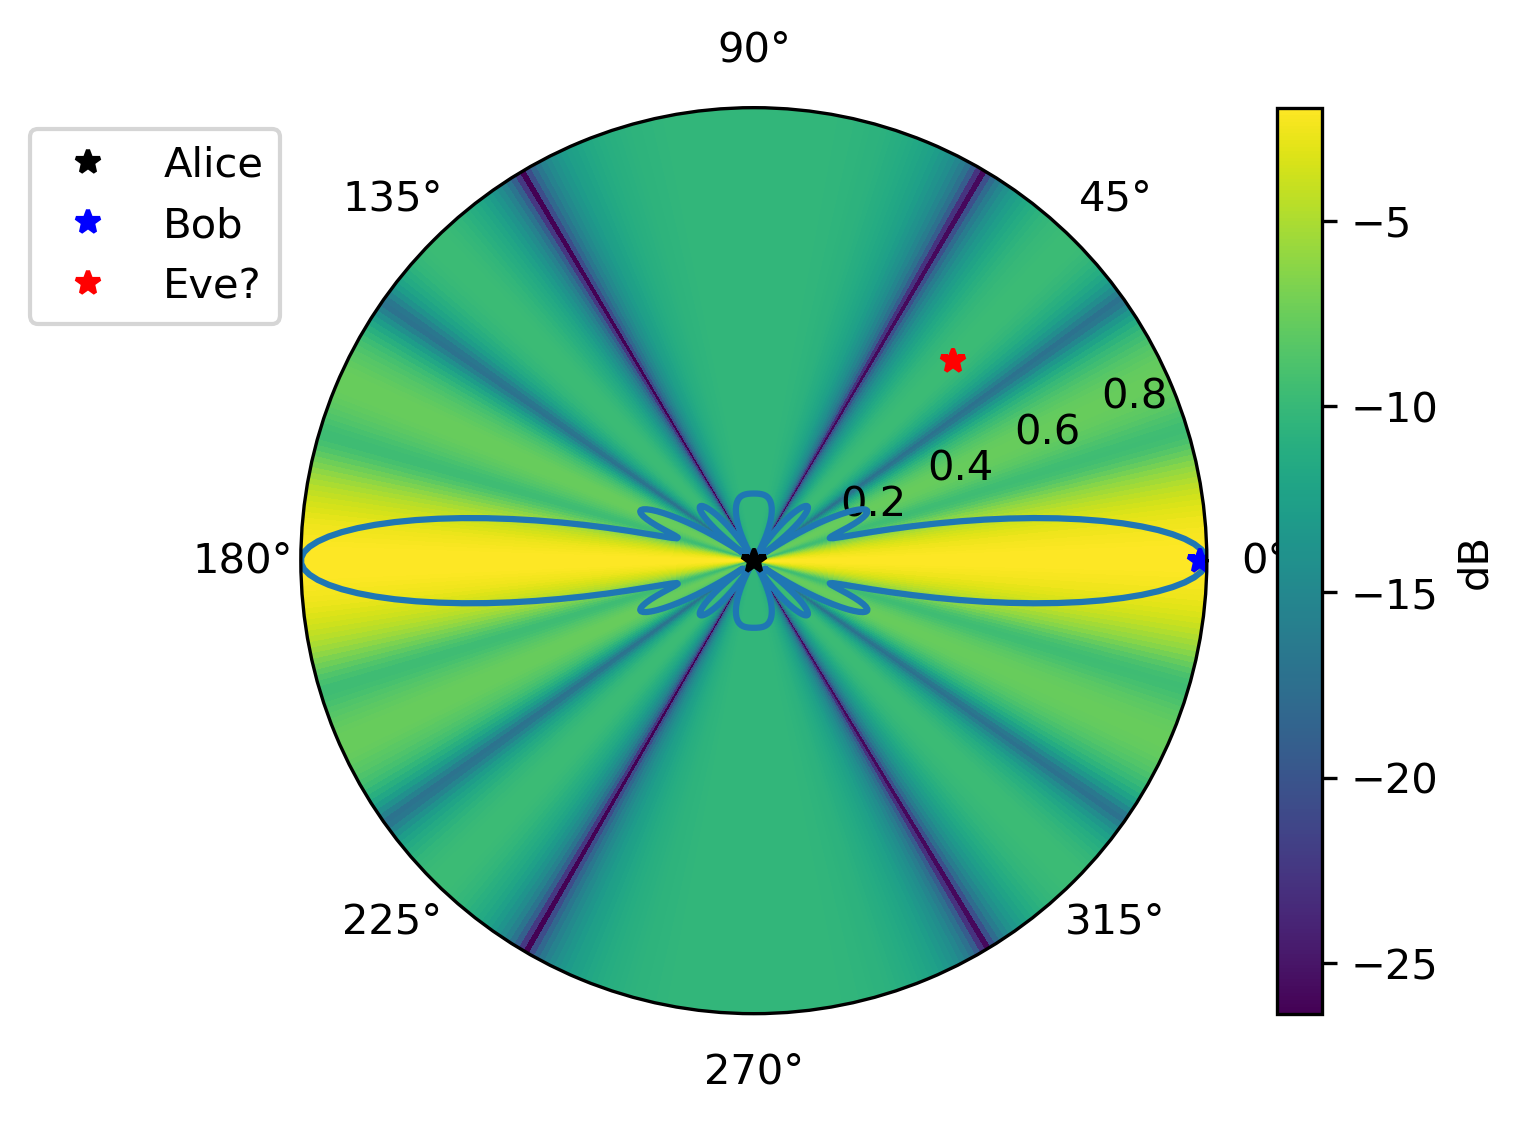

In [33]:
θ = np.linspace(0,2*π,num_points)
r = np.linspace(0,max(sig_beam),num_points)
R,Θ = np.meshgrid(r,θ)
plt.polar(θ,sig_beam)
plt.polar(0,0,'*k',label="Alice")
plt.polar(0,.95,'*b',label="Bob")
plt.polar(π/4,0.6,'*r',label="Eve?")
plt.pcolor(Θ,R,SINR)
plt.legend(bbox_to_anchor=(0,1))
plt.colorbar(label="dB")
#plt.title(f'SINR: θ={beams}, ν={ν}')
plt.savefig("SINR Colormap")
plt.show()

In [32]:
import imageio
plot = imageio.imread(f"SINR Colormap.png")
imageio.imwrite(f"SINR Colormap.jpg",plot[:,:,0])

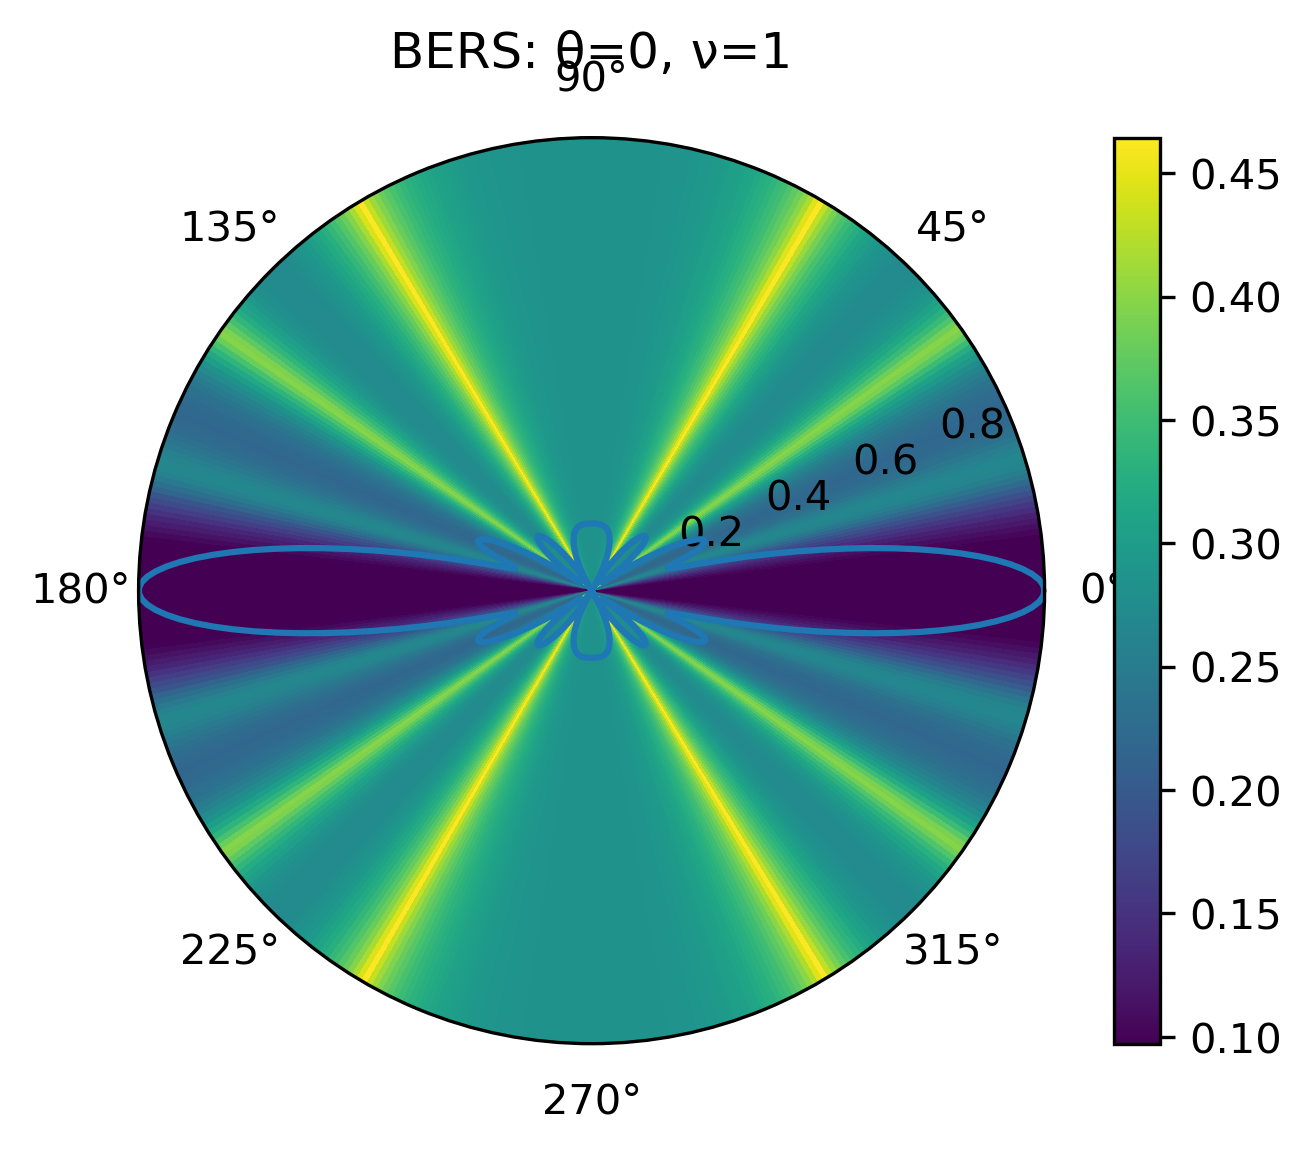

In [10]:
plt.polar(θ,sig_beam)
plt.pcolor(Θ,R,BER)
plt.colorbar()
plt.title(f'BERS: θ={beams}, ν={ν}')
plt.show()

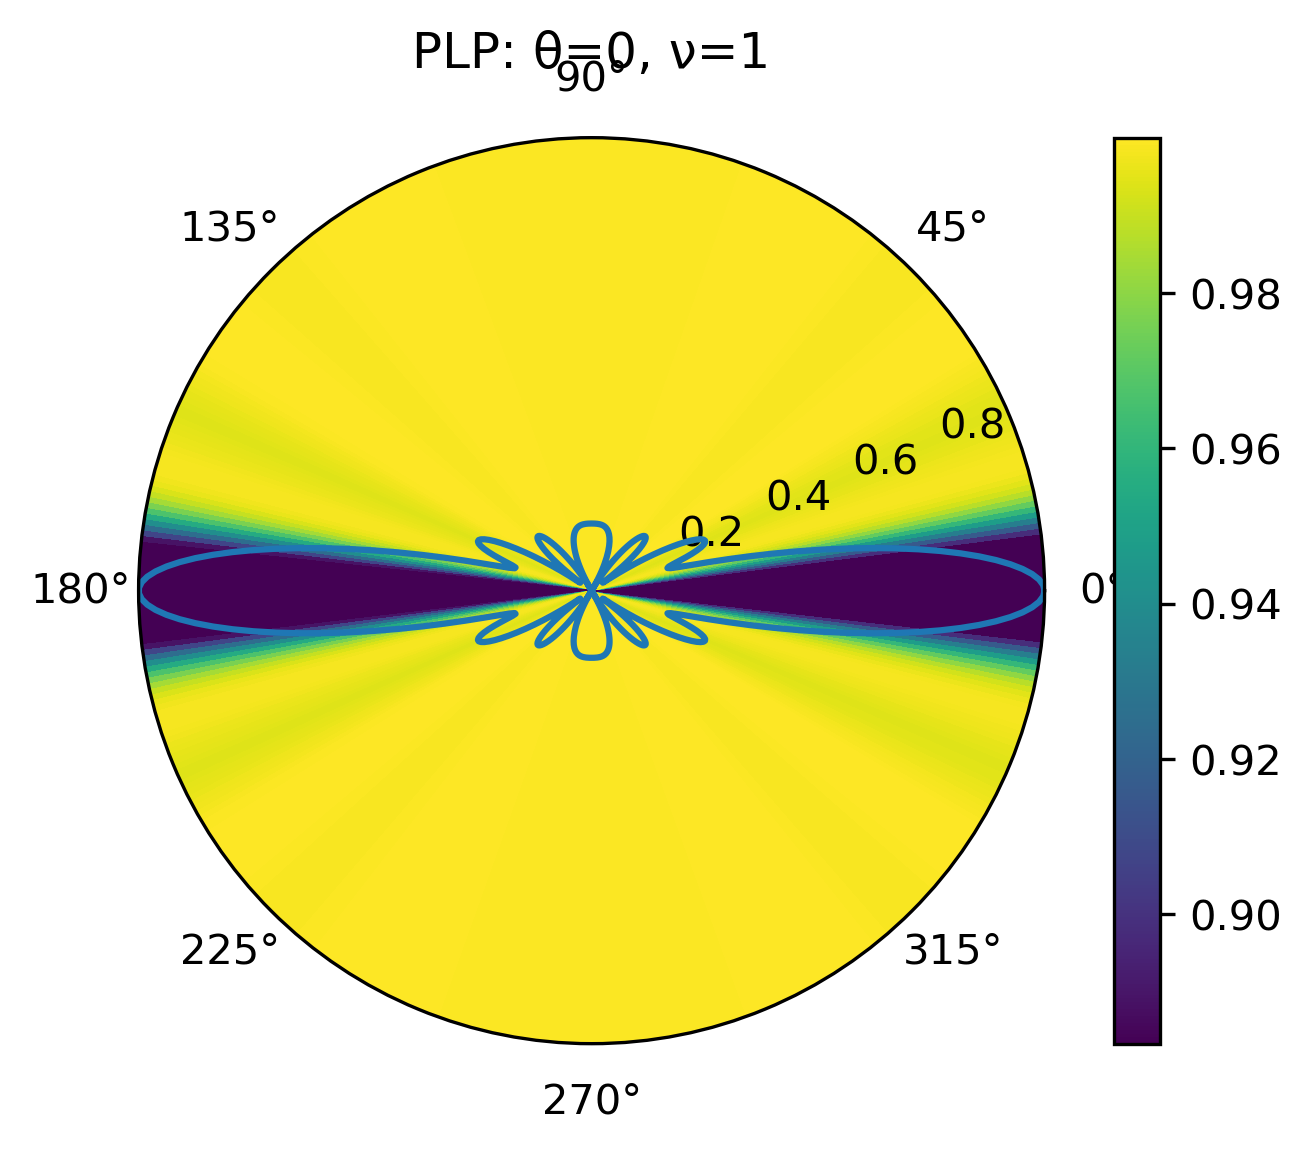

In [11]:
plt.polar(θ,sig_beam)
plt.pcolor(Θ,R,PLP)
plt.colorbar()
plt.title(f'PLP: θ={beams}, ν={ν}')
plt.show()

### Moving the beam

In [9]:
N = 7                                                 # Number of antenna
λ = 1                                                 # Wavelength
ν = 1                                                 # Functional Beamforming Exponent
σ2_awgn = 1                                           # Noise/AWGN variance
σ2_ray = 1                                            # Noise/Fading variance
beam_cent = π/4                                     # Azmith angle to Bob
num_packets = 51
beams = np.linspace(beam_cent-π/12,beam_cent+π/12,num_packets)
s_k = 10                                              # Alice's signal strength
packet_len = 10
func = lambda x : x**(1/ν)
θs = np.linspace(0,2*π,num_points)
all_beams = []
SINRs = np.zeros((num_points,num_points,num_packets))
BERs = np.zeros((num_points,num_points,num_packets))
PLPs = np.zeros((num_points,num_points,num_packets))
hsig = np.random.normal(loc=np.array([0,0]),scale=np.array([σ2_ray,σ2_ray]),size=(N,2))
hsig = 1/sqrt(2)*(hsig[:,0] + 1j*hsig[:,1])
start = time()
for i in range(num_packets) :
    ak = weights(beams[i],N,s_k,λ)
    sig_beam = [abs(dst(θ,s_k,N,λ)@ak) for θ in θs]
    all_beams.append(sig_beam)
    signal_beam = [sig_beam,ak]
    SINRs[:,:,i], BERs[:,:,i], PLPs[:,:,i] = sinr_ber_plp(signal_beam,[],var_awgn=σ2_awgn,var_ray=σ2_ray,dist_fad_exp=2,verbose=False,h_sig=hsig)
end = time()
all_beams = np.array(all_beams)
print(f'Took {(end-start)//3600} hour(s), {((end-start)%3600)//60} minute(s) and {(((end-start)%3600)%60)} seconds.')

Took 0.0 hour(s), 0.0 minute(s) and 18.28603506088257 seconds.


In [10]:
np.save('../../../IRES_Files/Beams_Reg',all_beams)
np.save('../../../IRES_Files/SINRs_Reg',SINRs)
np.save('../../../IRES_Files/BERs_Reg',BERs)
np.save('../../../IRES_Files/PLPs_Reg',PLPs)

In [11]:
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


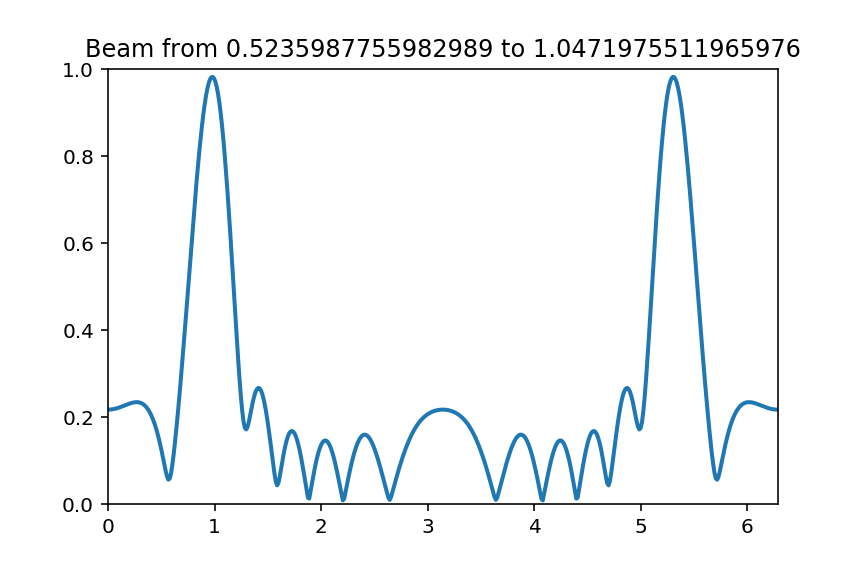

In [12]:
"""
https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
"""

# Initialize values
fig = plt.figure()
ax = plt.axes(xlim=(0,2*π),ylim=(0,1))
ax.set_title(f'Beam from {π/4-π/12} to {π/4+π/12}')
beam, = ax.plot([],[],lw=2)

# Define constructor fucntion
def constructor() :
    beam.set_data([],[])
    return beam,

# Define animation function
def animating(i) :
    θ = np.linspace(0,2*π,num_points)
    r = all_beams[i,:]
    beam.set_data(θ,r)
    return beam,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animating, init_func=constructor,frames=num_packets, interval=20, blit=True)
# Something's wrong with the save
#anim.save('../../../IRES_Files/Animations/reg_beam.html', fps=30, extra_args=['-vcodec', 'libx264'])
#plt.show()

<IPython.core.display.Javascript object>


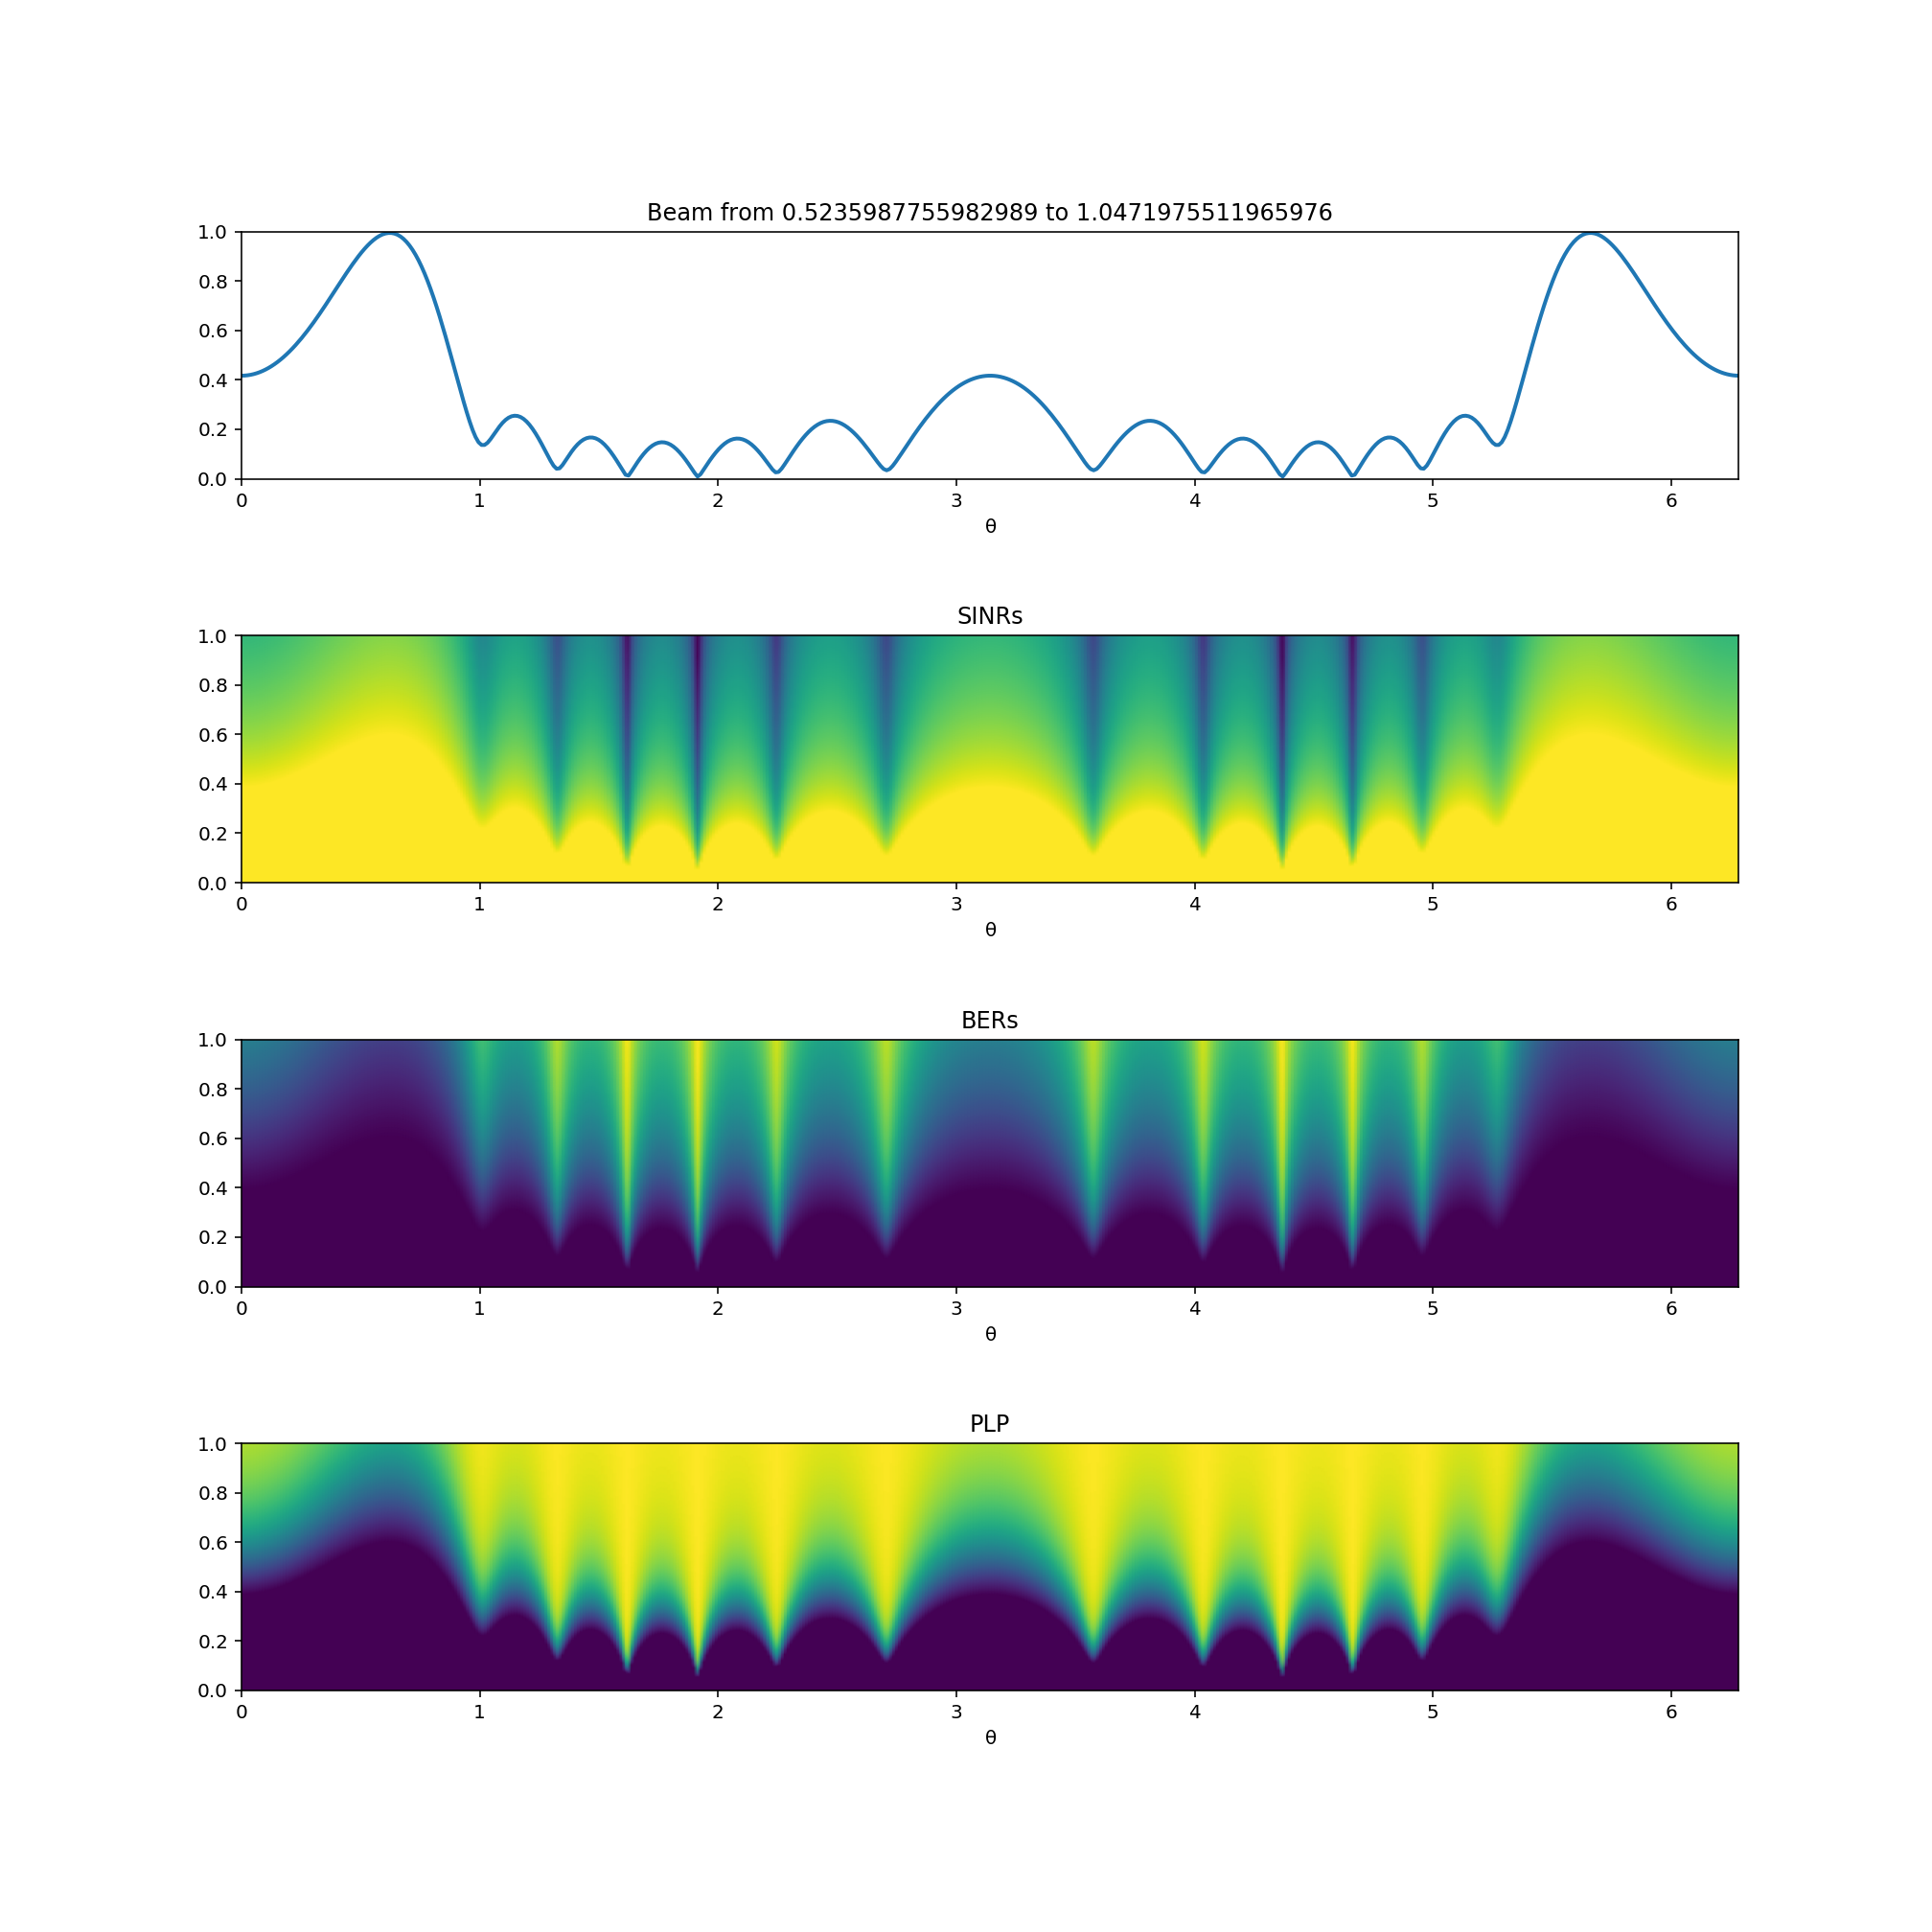

In [13]:
%matplotlib notebook
# Initialize values
fig = plt.figure(figsize=(14,14), facecolor='white')
gs = gridspec.GridSpec(11,1)

ax1 = plt.subplot(gs[:2,:])
ax1.set_xlim(0,2*π)
ax1.set_ylim(0,1)
ax1.set_xlabel('θ')
ax1.set_title(f'Beam from {beam_cent-π/12} to {beam_cent+π/12}')
beam, = ax1.plot([],[],lw=2)

R, Θ = np.meshgrid(np.linspace(0,1,num_points),np.linspace(0,2*π,num_points))
SNR = SINRs[:,:,0]
ax2 = plt.subplot(gs[3:5,:])
ax2.set_xlim(0,2*π)
ax2.set_ylim(0,1)
ax2.set_xlabel('θ')
ax2.set_title(f'SINRs')
snr = ax2.pcolormesh(Θ,R,SNR,shading='gouraud')
#cb = fig.colorbar(snr)

BER = BERs[:,:,0]
ax3 = plt.subplot(gs[6:8,:])
ax3.set_xlim(0,2*π)
ax3.set_ylim(0,1)
ax3.set_xlabel('θ')
ax3.set_title(f'BERs')
ber = ax3.pcolormesh(Θ,R,BER,shading='gouraud')

PLP = PLPs[:,:,0]
ax4 = plt.subplot(gs[9:,:])
ax4.set_xlim(0,2*π)
ax4.set_ylim(0,1)
ax4.set_xlabel('θ')
ax4.set_title(f'PLP')
plp = ax4.pcolormesh(Θ,R,PLP,shading='gouraud')

# Define constructor fucntion
def constructor() :
    beam.set_data([],[])
    snr.set_array(np.array([]))
    ber.set_array(np.array([]))
    plp.set_array(np.array([]))
    return beam,snr,ber,plp

# Define animation function
def animating(i) :
    θ = np.linspace(0,2*π,num_points)
    r = all_beams[i,:]
    beam.set_data(θ,r)
    snr.set_array(SINRs[:,:,i].ravel())
    ber.set_array(BERs[:,:,i].ravel())
    plp.set_array(PLPs[:,:,i].ravel())
    return beam,snr,ber,plp

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animating, init_func=constructor,frames=num_packets, interval=20, blit=True)
# Something's wrong with the save
#anim.save('Reg_Full.html', writer='ffmpeg', fps=30, extra_args=['-vcodec', 'libx264'])
#plt.show()

In [20]:
mins = []
for i in range(100) :
    start = time()
    SINR, BER, PLP = sinr_ber_plp(signal_beam,[],var_awgn=σ2_awgn,var_ray=σ2_ray,pack_len=packet_len,verbose=False)#,dist_fad_exp=2)
    end = time()
    #print(f'Took {(end-start)//3600} hour(s), {((end-start)%3600)//60} minute(s) and {(((end-start)%3600)%60)} seconds.')
    mins.append(np.min(PLP))
print(sum(mins)/len(mins))

0.45320007319674027
